In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
#from pandas_profiling import ProfileReport
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import Birch
from numpy import array
from numpy import reshape
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn.metrics import mean_squared_error


In [2]:
train_data = pd.read_csv("CensusCanada2016Training.csv")
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 15 columns):
 #   Column                                                                     Non-Null Count  Dtype  
---  ------                                                                     --------------  -----  
 0   Total Population                                                           5000 non-null   int64  
 1   Total Households                                                           5000 non-null   int64  
 2   Median Household Income (Current Year $)                                   5000 non-null   float64
 3   Total Households For Period Of Construction                                5000 non-null   int64  
 4   Total Households For Period Of Construction Built Before 1961              5000 non-null   int64  
 5   Total Households For Period Of Construction Built Between 1961 And 1980    5000 non-null   int64  
 6   Total Households For Period Of Construction Built Betwee

# EDA and Data Preprocessing

`Total Households = Total House holds for construction

Total House holds for construction 2006/2016 =Total House holds for construction - (SUM OF Total House holds for construction from all other time periods)

Total Households = Total Households For Structure Type House + Total Households For Structure Type Apartment, Building Low And High Rise + Total Households For Structure Type Other Dwelling Types

Total Households for Tenure = Dwellings by Tenure Owner    + Dwellings by Tenure Renter

Total empty = Total Households - Total Households for Tenure  

CREATE:

TOTAL EMPTY

TOTAL HOUSE 2006/2016

DELETE:

Total Households For Period Of Construction

Total Households for Tenure`




In [3]:
train_data = train_data.rename(columns={'Median Household Income (Current Year $)': 'Median Household Income',
'Total Households For Period Of Construction Built Before 1961':'Construction_1961',
'Total Households For Period Of Construction Built Between 1961 And 1980':'Construction_1961_1980',
'Total Households For Period Of Construction Built Between 1981 And 190':'Construction_1981_190',
'Total Households For Period Of Construction Built Between 1991 And 2000':'Construction_1991_2000',
'Total Households For Period Of Construction Built Between 2001 And 2005':'Construction_2001_2005',
'Total Households For Structure Type Houses':'Houses',
'Total Households For Structure Type Apartment, Building Low And High Rise':'Apartment_Building',
'Total Households For Structure Type Other Dwelling Types':'Other Dwelling Type'
                                       })

In [4]:
#Add additional column
train_data['Construction_2006_2016'] = train_data['Total Households']-(train_data['Construction_1961']+train_data['Construction_1961_1980']+train_data['Construction_1981_190']+train_data['Construction_1991_2000']+train_data['Construction_2001_2005'])
train_data['No_Dwellings'] = train_data['Total Households'] - train_data['Total Households for Tenure']

In [5]:
#remove columns
train_data = train_data.drop([
'Total Households', 
'Total Households For Period Of Construction', 
'Total Households for Tenure'], axis = 1)

In [6]:
train_data.head()

,Total Population,Median Household Income,Construction_1961,Construction_1961_1980,Construction_1981_190,Construction_1991_2000,Construction_2001_2005,Houses,Apartment_Building,Other Dwelling Type,Dwellings by Tenure Owner,Dwellings by Tenure Renter,Construction_2006_2016,No_Dwellings
0,4051,68242.12,323,199,53,182,526,911,525,5,919,424,158,98
1,2329,88172.37,927,70,15,3,0,792,230,4,778,213,11,35
2,5276,103853.38,3,607,567,651,106,1418,652,1,1522,381,137,168
3,5967,82796.63,133,1695,248,79,0,1397,806,0,1272,807,48,124
4,4236,91648.22,0,7,127,938,143,914,505,0,1186,162,204,71


In [7]:
train_data.describe()

,Total Population,Median Household Income,Construction_1961,Construction_1961_1980,Construction_1981_190,Construction_1991_2000,Construction_2001_2005,Houses,Apartment_Building,Other Dwelling Type,Dwellings by Tenure Owner,Dwellings by Tenure Renter,Construction_2006_2016,No_Dwellings
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.00000,5000.000000,5000.00000,5000.000000,5000.000000,5000.00000,5000.000000,5000.00000,5000.000000
mean,4866.967400,77241.071536,386.510600,555.437800,260.48240,237.92820,138.595600,1134.79180,777.188400,15.796000,1182.21140,628.155800,348.82160,116.821400
std,2491.841571,33371.567357,416.908471,448.327845,257.86717,265.43332,221.809214,812.09222,891.021549,62.949187,710.51703,594.295093,626.01298,116.067238
min,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.00000,-57.000000
25%,3289.750000,53040.835000,47.000000,192.000000,74.00000,58.00000,17.000000,534.00000,146.000000,0.000000,687.00000,201.000000,60.00000,54.000000
50%,4655.000000,76206.780000,238.000000,470.000000,181.00000,143.00000,52.000000,1076.00000,487.000000,2.000000,1112.00000,456.000000,142.00000,98.000000
75%,6233.750000,95438.495000,613.000000,830.000000,369.00000,325.00000,157.000000,1592.00000,1119.000000,6.000000,1570.00000,879.000000,367.25000,150.000000
max,30789.000000,669559.560000,2411.000000,3547.000000,1740.00000,2360.00000,2262.000000,9123.00000,15248.000000,1378.000000,8628.00000,6813.000000,12039.00000,3497.000000


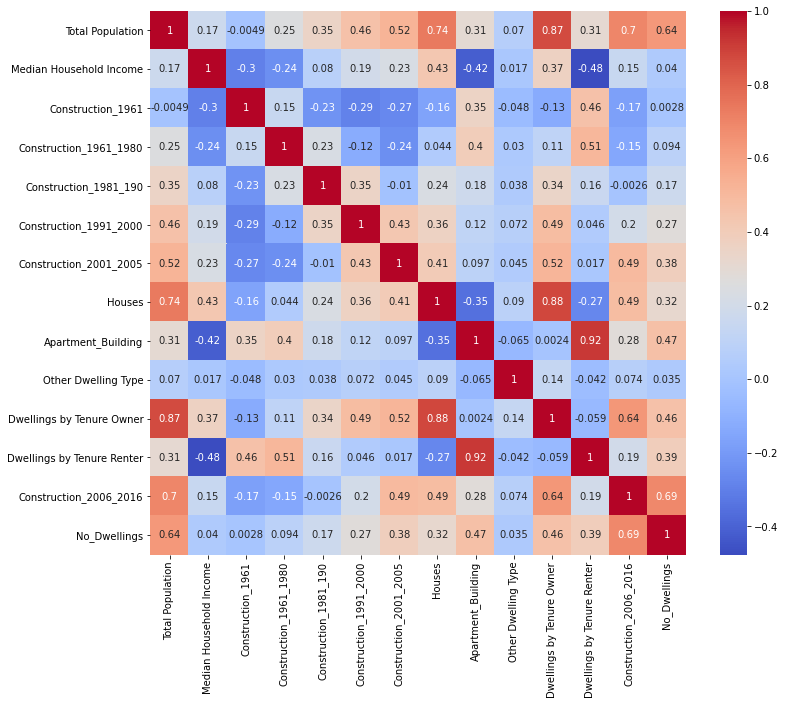

In [8]:
#Plot correlation matrix
correlations = train_data.corr()
plt.subplots(figsize=(12, 10))
sns.heatmap(correlations, annot=True, fmt = '.2g',cmap='coolwarm')
plt.show()

In [9]:
#Generate profile report to output.html
#profile_report = ProfileReport(train_data)
#profile_report.to_file(output_file='data_quality_output.html')

In [9]:
columns_lst = train_data.columns
columns_lst

Index(['Total Population', 'Median Household Income', 'Construction_1961',
       'Construction_1961_1980', 'Construction_1981_190',
       'Construction_1991_2000', 'Construction_2001_2005', 'Houses',
       'Apartment_Building', 'Other Dwelling Type',
       'Dwellings by Tenure Owner', 'Dwellings by Tenure Renter',
       'Construction_2006_2016', 'No_Dwellings'],
      dtype='object')

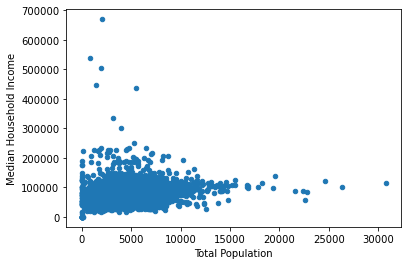

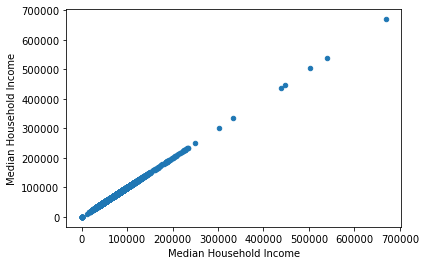

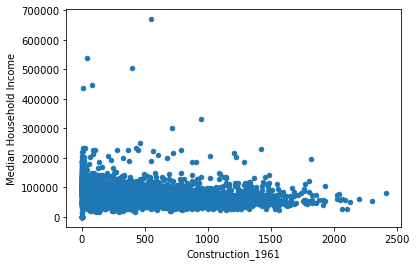

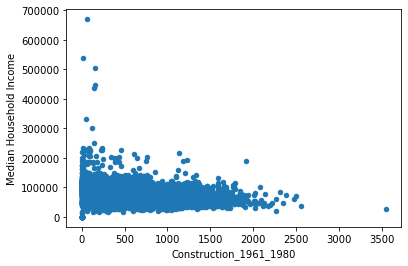

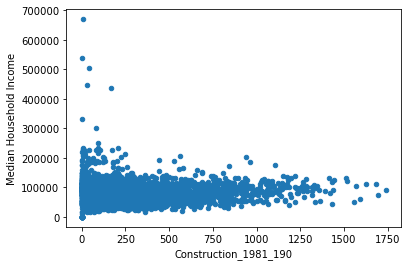

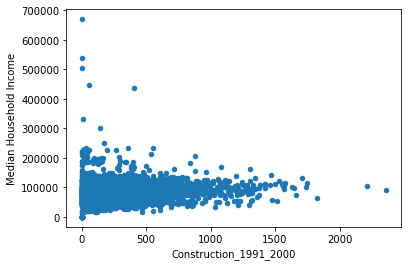

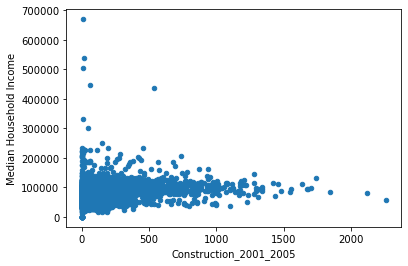

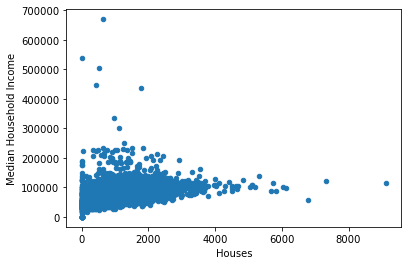

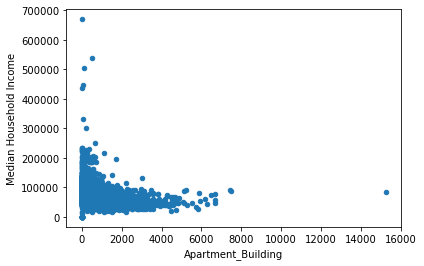

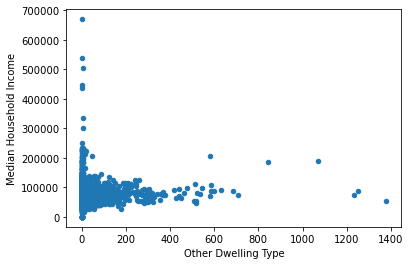

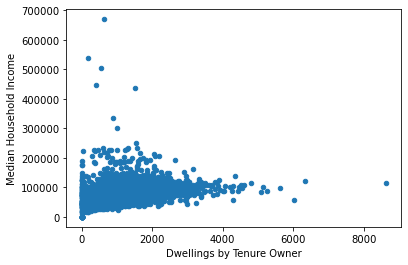

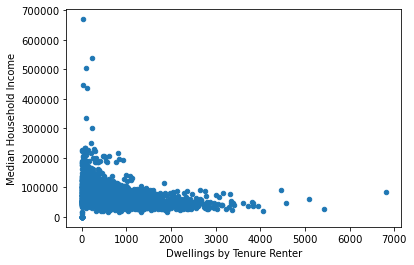

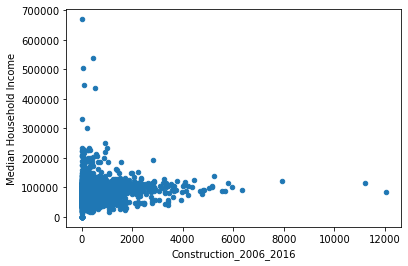

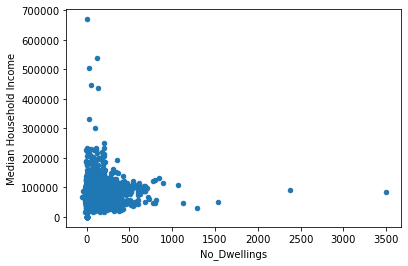

In [10]:
def make_plot(x,y):
    train_data.plot.scatter(x, y)
    plt.show()
for i in range(0,len(columns_lst)):
    make_plot(columns_lst[i],columns_lst[1])

In [10]:
#train_data.plot.scatter(x=columns_lst[12],y=columns_lst[13],c=columns_lst[2],colormap='viridis')

# Elbow Method

In [13]:
scaler = StandardScaler()
scaled_dataset = scaler.fit_transform(train_data)
scaled_dataset = pd.DataFrame(scaled_dataset, columns = columns_lst)

([<matplotlib.axis.XTick at 0x173c1cb6100>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

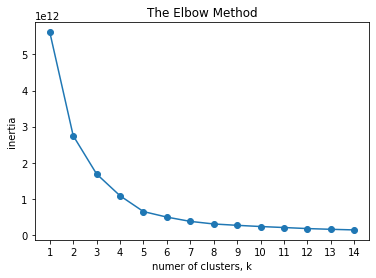

In [12]:
ks = range(1,15)
inertias = []
for k in ks:
    model = KMeans(n_clusters=k, random_state=1)
    model.fit(train_data)
    inertias.append(model.inertia_)
    
#print(inertias)
plt.title('The Elbow Method')
plt.plot(ks, inertias, '-o')
plt.xlabel('numer of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)

# KMEAN CLUSTERS

In [14]:
# scaler = StandardScaler()
# kmeans = KMeans(n_clusters=5, random_state=np.random.RandomState(1))
# pipeline = make_pipeline(scaler, kmeans)
# pipeline.fit(train_data)
kmeans = KMeans(n_clusters=5, random_state=1)
kmeans.fit(scaled_dataset)
kmeans.labels_.shape

(5000,)

In [15]:
train_data1 = train_data.copy()
train_data1['cluster']= kmeans.labels_ #pipeline.predict(scaled_dataset)

In [16]:
train_data1.groupby('cluster').agg({
    columns_lst[0]:['count', 'mean'],
    columns_lst[1]:'mean',
    columns_lst[2]:'mean',
    columns_lst[3]:'mean',
    columns_lst[4]:'mean',
    columns_lst[5]:'mean',
    columns_lst[6]:'mean',
    columns_lst[7]:'mean',
    columns_lst[8]:'mean',
    columns_lst[9]:'mean',
    columns_lst[10]:'mean',
    columns_lst[11]:'mean',
    columns_lst[12]:'mean',
    columns_lst[13]:'mean'
}).round(2)

Total Population          Median Household Income Construction_1961  \
                   count     mean                    mean              mean   
cluster                                                                       
0                   1605  5639.91                96742.19            190.65   
1                    389  9626.05                98278.97             97.73   
2                   2005  2866.69                69415.94            449.47   
3                     76  5707.71                82161.69            171.89   
4                    925  5791.08                51113.92            728.95   

        Construction_1961_1980 Construction_1981_190 Construction_1991_2000  \
                          mean                  mean                   mean   
cluster                                                                       
0                       577.84                424.61                 381.54   
1                       230.56                196.51                 445.38   
2                       394.04                108.13                  80.55   
3                       671.78                367.14                 369.25   
4                       993.46                324.07                 231.83   

        Construction_2001_2005   Houses Apartment_Building  \
                          mean     mean               mean   
cluster                                                      
0                       162.86  1616.82             405.40   
1                       645.90  2486.48             886.59   
2                        36.67   680.61             496.46   
3                       180.84  1555.51             303.78   
4                       100.61   679.87            2023.68   

        Other Dwelling Type Dwellings by Tenure Owner  \
                       mean                      mean   
cluster                                                 
0                     11.28                   1558.86   
1                     13.86                   2485.65   
2                      8.27                    687.39   
3                    410.80                   1763.09   
4                      8.30                   1005.36   

        Dwellings by Tenure Renter Construction_2006_2016 No_Dwellings  
                              mean                   mean         mean  
cluster                                                                 
0                           360.92                 296.00       113.69  
1                           609.50                1770.85       291.76  
2                           435.17                 116.47        61.39  
3                           379.30                 509.18       126.57  
4                          1538.45                 332.93       168.05

<AxesSubplot:xlabel='Attribute', ylabel='Value'>

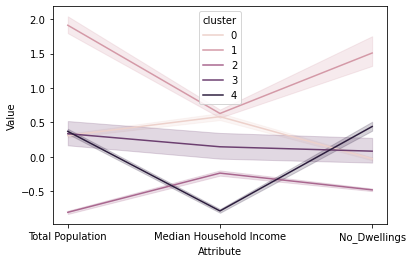

In [17]:
# smaler column list
columns_l = ['Total Population','Median Household Income','No_Dwellings']
# Create the dataframe
df_normalized = pd.DataFrame(scaled_dataset, columns=columns_l)
df_normalized['ID'] = train_data1.index
df_normalized['cluster'] = kmeans.labels_
# Melt The Data
df_nor_melt = pd.melt(df_normalized.reset_index(),
                      id_vars=['ID', 'cluster'],
                      value_vars=columns_l,
                      var_name='Attribute',
                      value_name='Value')
df_nor_melt.head()
# Visualize it
sns.lineplot(x='Attribute', y='Value', hue='cluster', data=df_nor_melt)

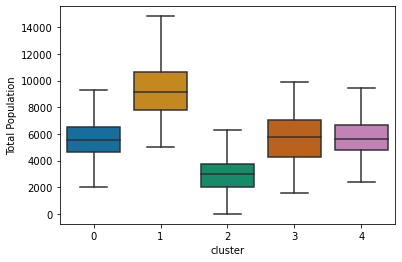

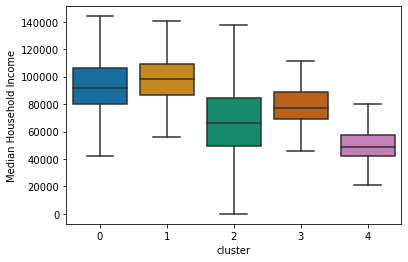

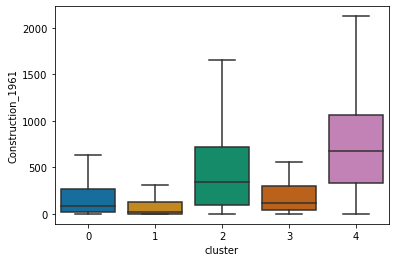

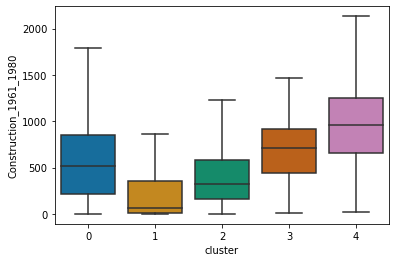

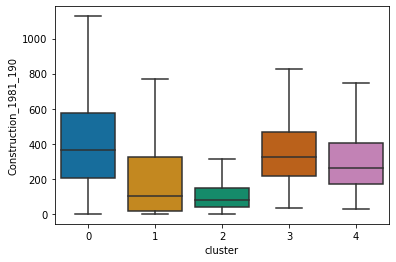

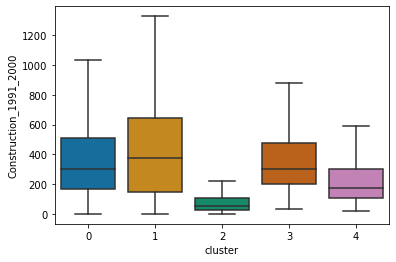

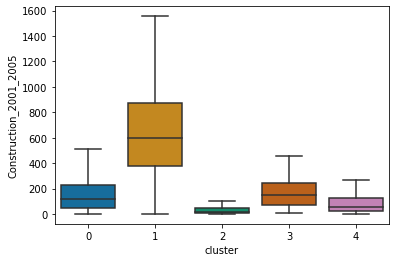

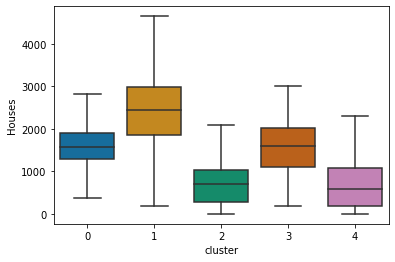

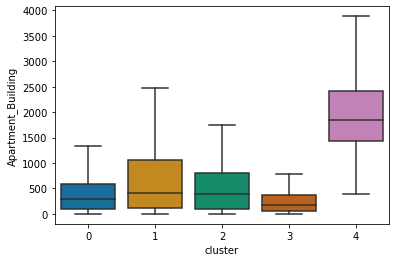

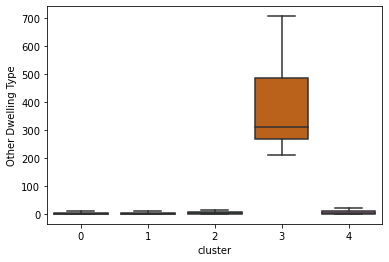

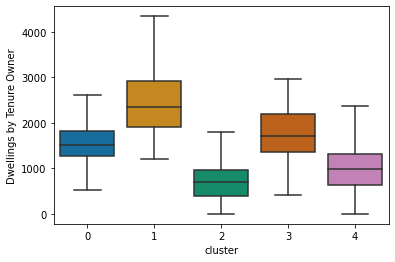

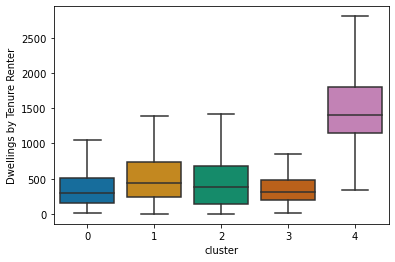

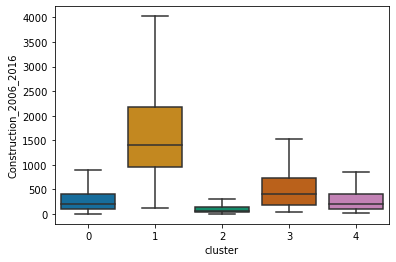

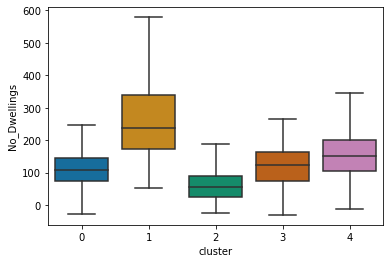

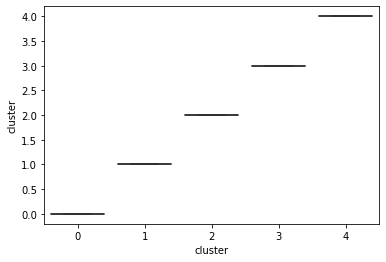

In [18]:
for name in train_data1.columns:
    plt.figure()
    sns.boxplot(y=name, x='cluster', 
                     data=train_data1, 
                     palette="colorblind",
                showfliers = False
                     )

In [19]:
def cluster_plot(a,b):
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111)#, projection='3d')
    ax.scatter(train_data1[a][train_data1.cluster == 0], train_data1[b][train_data1.cluster == 0])#, train_data["No_Dwellings"][train_data.cluster == 0], c='blue', s=60)
    ax.scatter(train_data1[a][train_data1.cluster == 1], train_data1[b][train_data1.cluster == 1])#, train_data["No_Dwellings"][train_data.cluster == 1], c='red', s=60)
    ax.scatter(train_data1[a][train_data1.cluster == 2], train_data1[b][train_data1.cluster == 2])#, train_data["No_Dwellings"][train_data.cluster == 2], c='green', s=60)
    ax.scatter(train_data1[a][train_data1.cluster == 3], train_data1[b][train_data1.cluster == 3])#, train_data["No_Dwellings"][train_data.cluster == 3], c='orange', s=60)
    ax.scatter(train_data1[a][train_data1.cluster == 4], train_data1[b][train_data1.cluster == 4])#, train_data["No_Dwellings"][train_data.cluster == 4], c='purple', s=60)
#ax.view_init(30, 185)
    plt.xlabel(a)
    plt.ylabel(b)
    

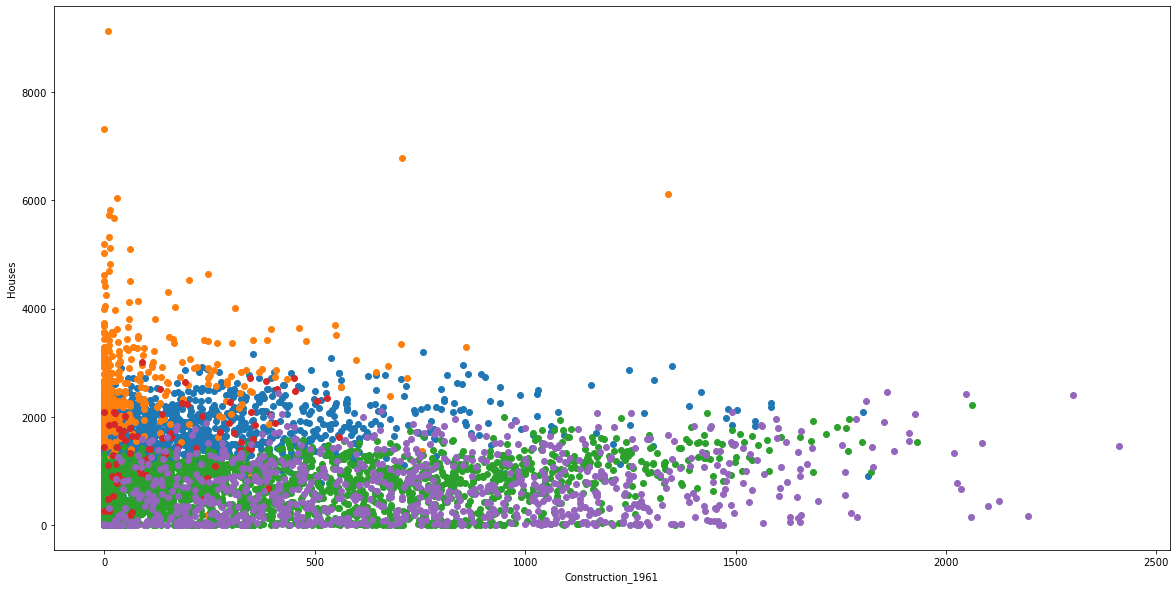

In [20]:
cluster_plot('Construction_1961','Houses')
#train_data1

# BIRCH CLUSTERS

In [21]:
birch = Birch(n_clusters=5)
birch.fit(scaled_dataset)
birch.labels_.shape

(5000,)

In [22]:
train_data2 = train_data.copy()
train_data2['cluster']= birch.labels_ #birch.predict(scaled_dataset)

In [23]:
train_data2.groupby('cluster').agg({
    columns_lst[0]:['count', 'mean'],
    columns_lst[1]:'mean',
    columns_lst[2]:'mean',
    columns_lst[3]:'mean',
    columns_lst[4]:'mean',
    columns_lst[5]:'mean',
    columns_lst[6]:'mean',
    columns_lst[7]:'mean',
    columns_lst[8]:'mean',
    columns_lst[9]:'mean',
    columns_lst[10]:'mean',
    columns_lst[11]:'mean',
    columns_lst[12]:'mean',
    columns_lst[13]:'mean'
}).round(2)

Total Population           Median Household Income Construction_1961  \
                   count      mean                    mean              mean   
cluster                                                                        
0                   1457   5908.81                97141.52            132.08   
1                   2719   3554.36                70103.82            496.35   
2                    626   6477.92                54719.16            593.66   
3                    149  11662.17               105622.04             80.50   
4                     49   5480.94                82979.77            140.96   

        Construction_1961_1980 Construction_1981_190 Construction_1991_2000  \
                          mean                  mean                   mean   
cluster                                                                       
0                       427.12                434.41                 430.90   
1                       558.87                139.47                  96.06   
2                       925.86                397.94                 362.19   
3                       143.51                148.81                 388.57   
4                       700.65                387.24                 326.61   

        Construction_2001_2005   Houses Apartment_Building  \
                          mean     mean               mean   
cluster                                                      
0                       251.99  1702.31             357.47   
1                        42.04   813.77             646.34   
2                       204.63   681.35            2393.65   
3                       503.94  3256.95             639.97   
4                       170.20  1413.41             284.29   

        Other Dwelling Type Dwellings by Tenure Owner  \
                       mean                      mean   
cluster                                                 
0                     14.81                   1628.97   
1                     10.04                    828.67   
2                      7.07                   1205.72   
3                     11.34                   3000.27   
4                    489.29                   1687.41   

        Dwellings by Tenure Renter Construction_2006_2016 No_Dwellings  
                              mean                   mean         mean  
cluster                                                                 
0                           321.76                 398.10       123.86  
1                           564.58                 137.35        75.84  
2                          1657.96                 597.79       218.38  
3                           541.17                2642.91       366.79  
4                           374.94                 461.31       123.92

<AxesSubplot:xlabel='Attribute', ylabel='Value'>

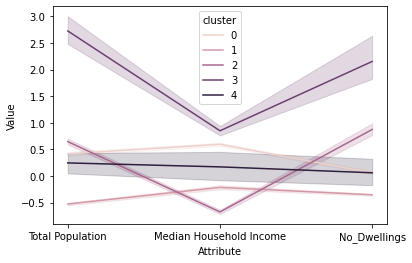

In [24]:
# smaler column list
columns_l = ['Total Population','Median Household Income','No_Dwellings']
# Create the dataframe
df_normalized = pd.DataFrame(scaled_dataset, columns=columns_l)
df_normalized['ID'] = train_data2.index
df_normalized['cluster'] = birch.labels_
# Melt The Data
df_nor_melt = pd.melt(df_normalized.reset_index(),
                      id_vars=['ID', 'cluster'],
                      value_vars=columns_l,
                      var_name='Attribute',
                      value_name='Value')
df_nor_melt.head()
# Visualize it
sns.lineplot(x= 'Attribute', y= 'Value', hue='cluster', data=df_nor_melt)

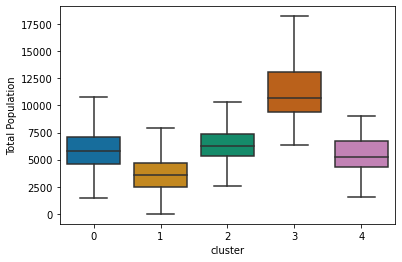

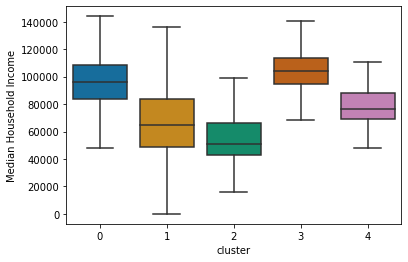

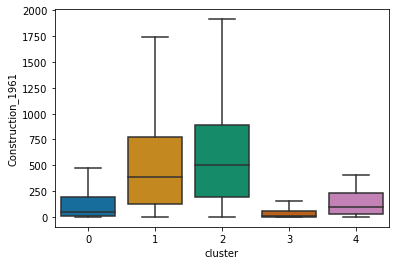

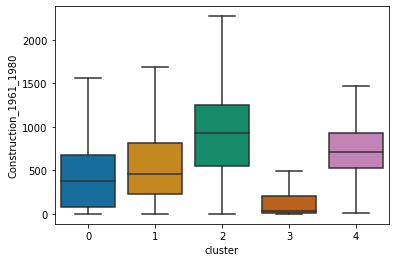

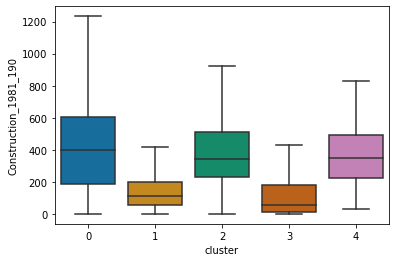

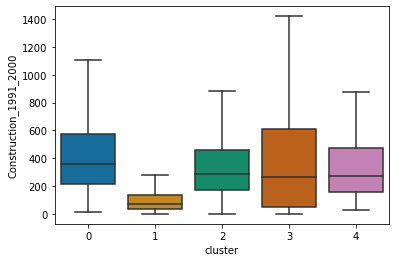

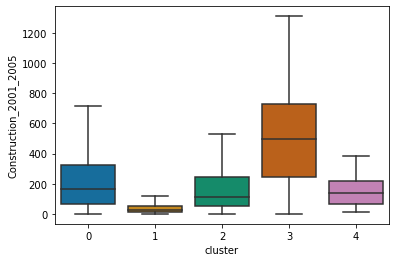

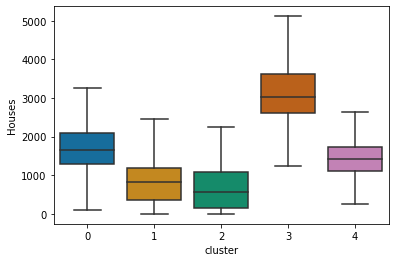

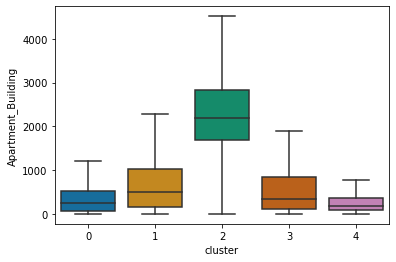

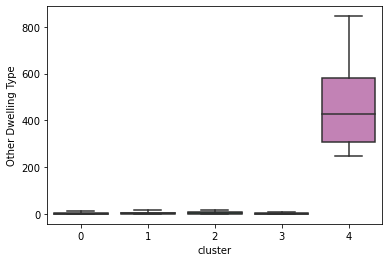

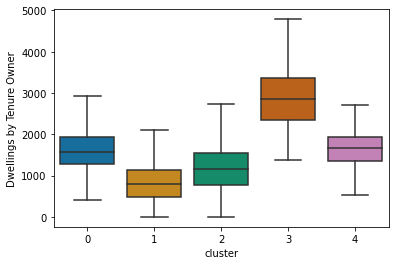

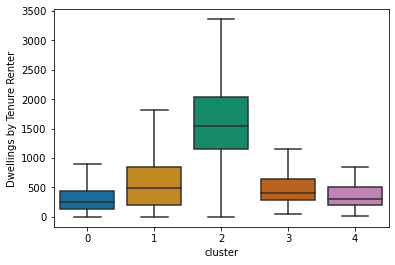

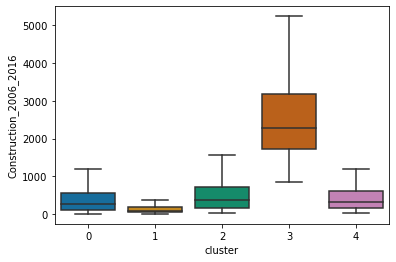

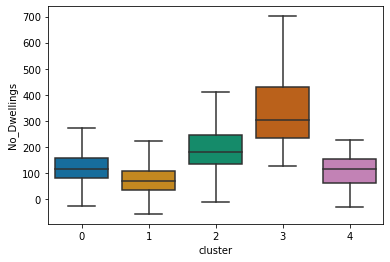

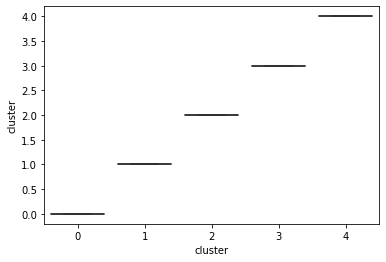

In [26]:
for name in train_data2.columns:
    plt.figure()
    sns.boxplot(y=name, x='cluster', 
                     data=train_data2, 
                     palette="colorblind",
                showfliers = False
                     )

# BEST MODEL without target

In [27]:
train_data3 = train_data.copy()
train_data3=train_data3.drop(columns=["Median Household Income"])

In [28]:
scaler = StandardScaler()
scaled_dataset2 = scaler.fit_transform(train_data3)
scaled_dataset2 = pd.DataFrame(scaled_dataset2, columns = train_data3.columns)
scaled_dataset2.head()

,Total Population,Construction_1961,Construction_1961_1980,Construction_1981_190,Construction_1991_2000,Construction_2001_2005,Houses,Apartment_Building,Other Dwelling Type,Dwellings by Tenure Owner,Dwellings by Tenure Renter,Construction_2006_2016,No_Dwellings
0,-0.327488,-0.152352,-0.795118,-0.804690,-0.210726,1.746741,-0.275602,-0.283061,-0.171521,-0.370488,-0.343560,-0.304851,-0.162176
1,-1.018613,1.296552,-1.082882,-0.952068,-0.885163,-0.624904,-0.422152,-0.614175,-0.187408,-0.568954,-0.698638,-0.539694,-0.705019
2,0.164165,-0.919984,0.115022,1.188784,1.556372,-0.146968,0.348774,-0.140514,-0.235070,0.478275,-0.415922,-0.338400,0.440983
3,0.441498,-0.608133,2.542060,-0.048411,-0.598810,-0.624904,0.322912,0.032339,-0.250958,0.126383,0.300965,-0.480584,0.061855
4,-0.253239,-0.927180,-1.223419,-0.517692,2.637731,0.019859,-0.271907,-0.305510,-0.250958,0.005333,-0.784463,-0.231363,-0.394823


In [29]:
kmeans2 = KMeans(n_clusters=5, random_state=1)
kmeans2.fit(scaled_dataset2)
kmeans2.labels_.shape

(5000,)

In [30]:
train_data3['cluster']= kmeans2.labels_ #kmeans.predict(scaled_dataset)

In [31]:
train_data3.groupby('cluster').agg({
    columns_lst[0]:['count', 'mean'],
    columns_lst[2]:'mean',
    columns_lst[3]:'mean',
    columns_lst[4]:'mean',
    columns_lst[5]:'mean',
    columns_lst[6]:'mean',
    columns_lst[7]:'mean',
    columns_lst[8]:'mean',
    columns_lst[9]:'mean',
    columns_lst[10]:'mean',
    columns_lst[11]:'mean',
    columns_lst[12]:'mean',
    columns_lst[13]:'mean'
}).round(2)

Total Population           Construction_1961 Construction_1961_1980  \
                   count      mean              mean                   mean   
cluster                                                                       
0                   1417   5388.84            232.01                 740.29   
1                    701   7259.87             97.35                 255.20   
2                   1919   2771.82            450.52                 351.95   
3                    866   5796.97            761.41                 982.53   
4                     97  13096.76            119.73                 237.41   

        Construction_1981_190 Construction_1991_2000 Construction_2001_2005  \
                         mean                   mean                   mean   
cluster                                                                       
0                      451.95                 265.04                  94.06   
1                      254.13                 605.59                 495.95   
2                       99.57                  83.07                  39.40   
3                      315.88                 227.77                  98.19   
4                      198.30                 339.26                 529.81   

          Houses Apartment_Building Other Dwelling Type  \
            mean               mean                mean   
cluster                                                   
0        1542.72             449.53               18.35   
1        1964.86             510.51               35.29   
2         646.08             490.77                9.99   
3         654.08            2053.46                8.83   
4        3137.11            1762.89               14.61   

        Dwellings by Tenure Owner Dwellings by Tenure Renter  \
                             mean                       mean   
cluster                                                        
0                         1491.63                     414.32   
1                         1943.00                     393.91   
2                          658.80                     425.90   
3                          984.72                    1562.05   
4                         3282.15                    1108.47   

        Construction_2006_2016 No_Dwellings  
                          mean         mean  
cluster                                      
0                       227.25       104.65  
1                       802.43       173.70  
2                       122.33        60.63  
3                       330.60       169.60  
4                      3490.09       523.97

# Models Selection for Each Cluster

In [32]:

models=[]
models.append(('Linear Regression', LinearRegression()))
models.append(('Bagging', BaggingRegressor()))
models.append(('Decision Tree', DecisionTreeRegressor()))
models.append(('SVR', SVR()))
models.append(('Boosting', GradientBoostingRegressor()))
models.append(('RF', RandomForestRegressor()))
models.append(('Polynomial',make_pipeline(PolynomialFeatures(),LinearRegression())))

In [33]:
train_data_final = train_data.copy()
train_data_final['cluster']= kmeans2.labels_

In [34]:
## cluster 0 best and second best models: boosting and RF
## cluster 1 RF and boosting
## cluster 2 RF and boosting
## cluster 3 RF and linear regression
## cluster 4 linear regression and RF

### RF is the overall best model for every cluster
def model_score(cluster_num):
    df = train_data_final.loc[train_data_final['cluster'] == cluster_num]
    X = df.drop(columns=['Median Household Income', 'cluster'])
    y = df['Median Household Income']
    results = []
    names = []
    scoring = 'neg_mean_squared_error'
    MSE = []
    for name, model in models:
        kfold = KFold(n_splits=10, random_state=1,shuffle=True)
        cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg =  (name, cv_results.mean(), cv_results.std())
        MSE.append(msg)
    return(MSE)

In [35]:
k=[]
for i in range (5):
    cluster = i
    mse= model_score(i)
    k.append([cluster, mse])

In [36]:
for rows in k:
    print(rows[0])
    mse2=0
    name=""
    for row in rows[1]:  
        if (abs(row[1])<mse2 or mse2==0):
            mse2= abs(row[1])
            name=row[0]
        
    print(mse2)
    print(name)



0
280229343.1609829
RF
1
516114216.7599661
RF
2
1011497165.5446348
RF
3
180575775.92160666
Linear Regression
4
374284392.2477654
RF


# Starting Predictions with Selected Model

In [37]:
def data_split(c):
    X = train_data_final[train_data_final.cluster==c].drop(['Median Household Income','cluster'],axis = 1)
    y= train_data_final[train_data_final.cluster==c]['Median Household Income']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    return X_train, X_test, y_train, y_test 

# Random Forest

In [38]:
def random_forest(X_train,X_test,y_train,y_test):
    param_grid={'max_depth':[5,10,15,20,25]}
    gridSearch=GridSearchCV(RandomForestRegressor(random_state=1),param_grid,cv=5,n_jobs=-1)
    gridSearch.fit(X_train,y_train)
    #print('Score: ', gridSearch.best_score_)
    #print('Parameter: ', gridSearch.best_params_)
    param=gridSearch.best_params_.get('max_depth')
    RF=RandomForestRegressor(max_depth=param, random_state=0)
    RF.fit(X_train, y_train)
    y_pred=RF.predict(X_test)
    score= RF.score(X_test,y_test)
    return (pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})), score, RF

# Linear

In [39]:
def linear_reg(X_train,X_test,y_train,y_test):
    reg = linear_model.LinearRegression()
    reg.fit(X_train, y_train)
    y_pred=reg.predict(X_test)
    score= reg.score(X_test,y_test)
    return pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}), score, reg


# Boosting

In [40]:
def boosting(X_train,X_test,y_train,y_test):
    boost = GradientBoostingRegressor()
    boost.fit(X_train, y_train)
    y_pred=boost.predict(X_test)
    score= boost.score(X_test,y_test)
    return pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}), score, boost

# Bagging

In [41]:
def bagging(X_train,X_test,y_train,y_test):
    bag = BaggingRegressor()
    bag.fit(X_train, y_train)
    y_pred=bag.predict(X_test)
    score= bag.score(X_test,y_test)
    return pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}), score, bag

# Evaluate for cluster 0

In [42]:
X_train, X_test, y_train, y_test  = data_split(0)
print('RF for cluster:', 0)
RF_0 = random_forest(X_train,X_test,y_train,y_test)
print(RF_0[1])

RF for cluster: 0
0.38306427318791303


In [43]:
print('LR for cluseter:', 0)
LR_0=linear_reg(X_train,X_test,y_train,y_test)
print(LR_0[1])

LR for cluseter: 0
0.4490360289550904


In [44]:
print('Boosting for cluseter:', 0)
BOOST_0=boosting(X_train,X_test,y_train,y_test)
print(BOOST_0[1])

Boosting for cluseter: 0
0.42797372659498256


In [45]:
print('Bagging for cluseter:', 0)
BAG_0=bagging(X_train,X_test,y_train,y_test)
print(BAG_0[1])

Bagging for cluseter: 0
0.28314467492788153


# Evaluate for cluster 1

In [46]:
X_train, X_test, y_train, y_test  = data_split(1)
print('RF for cluster:', 1)
RF_1 = random_forest(X_train,X_test,y_train,y_test)
print(RF_1[1])

RF for cluster: 1
0.0001754311307794465


In [47]:
print('LR for cluseter:', 1)
LR_1=linear_reg(X_train,X_test,y_train,y_test)
print(LR_1[1])

LR for cluseter: 1
0.039575540516939345


In [48]:
print('Boosting for cluseter:', 1)
BOOST_1=boosting(X_train,X_test,y_train,y_test)
print(BOOST_1[1])

Boosting for cluseter: 1
-0.04497747614794667


In [49]:
print('Bagging for cluseter:', 1)
BAG_1=bagging(X_train,X_test,y_train,y_test)
print(BAG_1[1])

Bagging for cluseter: 1
-0.27358861241149635


# Evaluate for cluster 2

In [50]:
X_train, X_test, y_train, y_test  = data_split(2)
print('RF for cluster:', 2)
RF_2 = random_forest(X_train,X_test,y_train,y_test)
print(RF_2[1])

RF for cluster: 2
0.2837388321046169


In [51]:
print('LR for cluseter:', 2)
LR_2=linear_reg(X_train,X_test,y_train,y_test)
print(LR_2[1])

LR for cluseter: 2
0.18297013133296813


In [52]:
print('Boosting for cluseter:', 2)
BOOST_2=boosting(X_train,X_test,y_train,y_test)
print(BOOST_2[1])

Boosting for cluseter: 2
0.24830588221778238


In [53]:
print('Bagging for cluseter:', 2)
BAG_2=bagging(X_train,X_test,y_train,y_test)
print(BAG_2[1])

Bagging for cluseter: 2
0.27883205775460906


# Evaluate for cluster 3

In [54]:
X_train, X_test, y_train, y_test  = data_split(3)
print('RF for cluster:', 3)
RF_3 = random_forest(X_train,X_test,y_train,y_test)
print(RF_3[1])

RF for cluster: 3
0.3768758138979258


In [55]:
print('LR for cluseter:', 3)
LR_3=linear_reg(X_train,X_test,y_train,y_test)
print(LR_3[1])

LR for cluseter: 3
0.49430892051114383


In [56]:
print('Boosting for cluseter:', 3)
BOOST_3=boosting(X_train,X_test,y_train,y_test)
print(BOOST_3[1])

Boosting for cluseter: 3
0.2666248693968989


In [57]:
print('Bagging for cluseter:', 3)
BAG_3=bagging(X_train,X_test,y_train,y_test)
print(BAG_3[1])

Bagging for cluseter: 3
0.2925900911271455


# Evaluate for cluster 4

In [58]:
X_train, X_test, y_train, y_test  = data_split(4)
print('RF for cluster:', 4)
RF_4 = random_forest(X_train,X_test,y_train,y_test)
print(RF_4[1])

RF for cluster: 4
0.3814926393503


In [59]:
print('LR for cluseter:', 4)
LR_4=linear_reg(X_train,X_test,y_train,y_test)
print(LR_4[1])

LR for cluseter: 4
-0.44220428353077157


In [60]:
print('Boosting for cluseter:', 4)
BOOST_4=boosting(X_train,X_test,y_train,y_test)
print(BOOST_4[1])

Boosting for cluseter: 4
0.4297870937059115


In [61]:
print('Bagging for cluseter:', 4)
BAG_4=bagging(X_train,X_test,y_train,y_test)
print(BAG_4[1])

Bagging for cluseter: 4
0.4653271658424203


# Global

In [62]:
X = train_data_final.drop(['Median Household Income','cluster'],axis = 1)
y = train_data_final['Median Household Income']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
RF_ALL = random_forest(X_train,X_test,y_train,y_test)
print(RF_ALL[1])

0.4251698840937209


In [63]:
LR_ALL=linear_reg(X_train,X_test,y_train,y_test)
print(LR_ALL[1])

0.35121912778137077


In [64]:
BOOST_ALL=boosting(X_train,X_test,y_train,y_test)
print(BOOST_ALL[1])

0.38839855503031073


In [65]:
BAG_ALL=bagging(X_train,X_test,y_train,y_test)
print(BAG_ALL[1])

0.36874591479744867


# Predict on Test Data

In [66]:
test_data = pd.read_csv("CensusCanada2016Test.csv")
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 721 entries, 0 to 720
Data columns (total 14 columns):
 #   Column                                                                     Non-Null Count  Dtype
---  ------                                                                     --------------  -----
 0   Total Population                                                           721 non-null    int64
 1   Total Households                                                           721 non-null    int64
 2   Total Households For Period Of Construction                                721 non-null    int64
 3   Total Households For Period Of Construction Built Before 1961              721 non-null    int64
 4   Total Households For Period Of Construction Built Between 1961 And 1980    721 non-null    int64
 5   Total Households For Period Of Construction Built Between 1981 And 190     721 non-null    int64
 6   Total Households For Period Of Construction Built Between 1991 And 2000   

In [67]:
test_data = test_data.rename(columns={
'Total Households For Period Of Construction Built Before 1961':'Construction_1961',
'Total Households For Period Of Construction Built Between 1961 And 1980':'Construction_1961_1980',
'Total Households For Period Of Construction Built Between 1981 And 190':'Construction_1981_190',
'Total Households For Period Of Construction Built Between 1991 And 2000':'Construction_1991_2000',
'Total Households For Period Of Construction Built Between 2001 And 2005':'Construction_2001_2005',
'Total Households For Structure Type Houses':'Houses',
'Total Households For Structure Type Apartment, Building Low And High Rise':'Apartment_Building',
'Total Households For Structure Type Other Dwelling Types':'Other Dwelling Type'
                                       })
#Add additional column
test_data['Construction_2006_2016'] = test_data['Total Households']-(test_data['Construction_1961']+test_data['Construction_1961_1980']+test_data['Construction_1981_190']+test_data['Construction_1991_2000']+test_data['Construction_2001_2005'])
test_data['No_Dwellings'] = test_data['Total Households'] - test_data['Total Households for Tenure']

#remove
test_data = test_data.drop([
'Total Households', 
'Total Households For Period Of Construction', 
'Total Households for Tenure'], axis = 1)

In [68]:
columns_lst_test = test_data.columns
scaler = StandardScaler()
scaled_test = scaler.fit_transform(test_data)
scaled_test = pd.DataFrame(scaled_test, columns = columns_lst_test)
labels = kmeans2.predict(scaled_test)

print(len(labels))

721


In [69]:
test_data['cluster']= labels


In [70]:
test_data.head()

,Total Population,Construction_1961,Construction_1961_1980,Construction_1981_190,Construction_1991_2000,Construction_2001_2005,Houses,Apartment_Building,Other Dwelling Type,Dwellings by Tenure Owner,Dwellings by Tenure Renter,Construction_2006_2016,No_Dwellings,cluster
0,2692,15,21,46,648,114,883,10,0,790,46,49,57,2
1,3884,17,839,218,27,33,1025,486,0,1207,192,377,112,0
2,7014,767,615,223,435,166,1390,1378,0,1533,1019,562,216,3
3,9136,1540,969,437,244,457,2102,2461,14,2402,1830,930,345,3
4,3614,44,94,34,115,184,1069,98,0,1042,38,696,87,2


In [71]:
# Dictionary of all the clusters, based on cluster label

dict_of_test_labels= {}
for i in range(0,5):
    df = test_data.loc[test_data['cluster'] == i]
    dict_of_test_labels[str(i)] = df.drop(columns=[ 'cluster'])
    
#Useful for the later merge statement

join_on_this =list(dict_of_test_labels['0'].columns)

In [72]:
#Predict all the incomes
income_0 = RF_0[2].predict(dict_of_test_labels['0'])
income_1 = RF_1[2].predict(dict_of_test_labels['1'])
income_2 = RF_2[2].predict(dict_of_test_labels['2'])
income_3 = LR_3[2].predict(dict_of_test_labels['3'])
income_4 = BAG_4[2].predict(dict_of_test_labels['4'])

In [73]:
#add income into the dictionary
dict_of_test_labels['0']['Income'] = income_0 
dict_of_test_labels['1']['Income'] = income_1 
dict_of_test_labels['2']['Income'] = income_2 
dict_of_test_labels['3']['Income'] = income_3 
dict_of_test_labels['4']['Income'] = income_4 

In [74]:
#Concat the dictionary clusters into on DF

ALL_INCOME= pd.concat( [ dict_of_test_labels['0'],
                      dict_of_test_labels['1'] ,
                      dict_of_test_labels['2'] ,
                      dict_of_test_labels['3'] ,
                      dict_of_test_labels['4']  ])

#Merge the incomes and the orignal DF to have the proper order of incomes

FINAL_RESULTS= test_data.merge( ALL_INCOME, on = join_on_this, how="left")

INCOMES = FINAL_RESULTS['Income']

In [75]:
FINAL_RESULTS.head()

,Total Population,Construction_1961,Construction_1961_1980,Construction_1981_190,Construction_1991_2000,Construction_2001_2005,Houses,Apartment_Building,Other Dwelling Type,Dwellings by Tenure Owner,Dwellings by Tenure Renter,Construction_2006_2016,No_Dwellings,cluster,Income
0,2692,15,21,46,648,114,883,10,0,790,46,49,57,2,118328.461810
1,3884,17,839,218,27,33,1025,486,0,1207,192,377,112,0,95303.304898
2,7014,767,615,223,435,166,1390,1378,0,1533,1019,562,216,3,64537.024759
3,9136,1540,969,437,244,457,2102,2461,14,2402,1830,930,345,3,85998.790769
4,3614,44,94,34,115,184,1069,98,0,1042,38,696,87,2,120529.497083


In [76]:
#Print the incomes to a txt file

rounded = [round(p,2) for p in INCOMES]
test_output=open('FinalTeam10Predictions.txt','w')
for p in rounded:
    test_output.write(str(p))
    test_output.write('\n')
test_output.close()